### Generate wordcount plot for report
This script plots the wordcounts for two specified lists of games ('interesting_games_pos' and 'interesting_games_neg'). For the 'pos' list of games, the script plots the keywords of positive reviews, and for the 'neg' list of games, the script plots the keywords of negative reviews.
The script saves two separate figures in pdf-format, one for positive reviews and one for negative reviews.
The plotting function 'plot_most_interesting' provides different means of filtering the relative and positive appearance of keywords or combinations of words in the game reviews.

Isabel Schüle, January 2024

In [7]:
import pandas as pd
import numpy as np
import sys
sys.path.append('..')

from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib import font_manager
from tueplots import bundles
from tueplots.constants.color import rgb
from tueplots import figsizes, fonts

from utils import generate_sample_df, get_fallout_4_df, preprocess_df, analyze_reviews, filter_peaks

In [2]:
display(bundles.icml2022(column='full',nrows=1,ncols=1,usetex=False))

plt.rcParams.update(bundles.icml2022(column='full',nrows=1,ncols=1,usetex=False))
#matplotlib.rcParams['font.family'] = times_prop.get_name()
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['figure.constrained_layout.use'] = False
plt.rcParams['figure.figsize'] = (9.1, 2.8)

#print(plt.rcParams)

{'text.usetex': False,
 'font.serif': ['Times'],
 'mathtext.fontset': 'stix',
 'mathtext.rm': 'Times',
 'mathtext.it': 'Times:italic',
 'mathtext.bf': 'Times:bold',
 'font.family': 'serif',
 'figure.figsize': (6.75, 4.171729424061791),
 'figure.constrained_layout.use': True,
 'figure.autolayout': False,
 'savefig.bbox': 'tight',
 'savefig.pad_inches': 0.015,
 'font.size': 8,
 'axes.labelsize': 8,
 'legend.fontsize': 6,
 'xtick.labelsize': 6,
 'ytick.labelsize': 6,
 'axes.titlesize': 8}

In [3]:
def plot_most_interesting(df_dict_pos, df_dict_neg, word_plot_name='test_word_plot', max_df=1.0, min_df=20, ngram_range=(1,1), thresh_rel_diff=0.4, thresh_rel=0.0):
    # df_dict_pos:    dict of dataframes of games where the positive reviews will be visualized
    # df_dict_neg:    dict of dataframes of games where the negative reviews will be visualized
    # max_df:         maximum appearance of a keyword to be kept in the plot (1.0: keyword can appear in all reviews, 
    #                 integer > 1: absolute max number)
    # min_df:         minimum appearance of a keyword to be kept in the plot (0.01: even if keyword only appears in 
    #                 one percent of reviews it will be kept in the dataframe. Integer > 1: absolute min number)
    # ngram_range:    range of word combinations to be considered: 
    #                 (1,1) - only single words; (1,2) - single words and combinations of two words 
    # thresh_rel_diff:threshold for relative appearance of a keyword in positive compared to negative reviews.
    #                 reviews with a lower relative difference will be filtered out by the "filter_peaks" function
    #                 (if a word appears as often in negative reviews as in positive reviews)
    # thresh_rel:     threshold for relative appearance of a keyword compared to all reviews of that game.
    #                 Only the keywords that appear at least in one game more often (relative to all reviews of that game)
    #                 than the given threshold will be kept in the plot.
    
    df_list_processed_pos = []
    df_list_processed_neg = []
    game_list_pos = []
    game_list_neg = []
    
    for game in df_dict_pos.keys():
        game_list_pos.append(game)
        df = preprocess_df(df_dict_pos[game])

        rt_df_count, rt_df_tfidf = analyze_reviews(df, max_df=max_df, min_df=min_df, ngram_range=ngram_range)

        sum_df = filter_peaks(rt_df_count, thresh_rel_diff=thresh_rel_diff)
        #filter out keyword "game" as it appears so frequently and is not informative
        if sum_df.index.isin(['game']).any():
            sum_df.drop(index='game', inplace=True)
            
        #rename columns to include name of game
        sum_df.rename(columns={"neg": (game + "_neg"), "pos": (game + "_pos"), "rel_diff": (game + "_rel_diff"), "neg_rel_app": (game + "_neg_rel_app"), "pos_rel_app": (game + "_pos_rel_app")}, inplace=True)
        df_list_processed_pos.append(sum_df)
        
    for game in df_dict_neg.keys():
        game_list_neg.append(game)
        df = preprocess_df(df_dict_neg[game])

        rt_df_count, rt_df_tfidf = analyze_reviews(df, max_df=max_df, min_df=min_df, ngram_range=ngram_range)

        sum_df = filter_peaks(rt_df_count, thresh_rel_diff=thresh_rel_diff)
        #filter out keyword "game" as it appears so frequently and is not informative
        if sum_df.index.isin(['game']).any():
            sum_df.drop(index='game', inplace=True)
            
        #rename columns to include name of game
        sum_df.rename(columns={"neg": (game + "_neg"), "pos": (game + "_pos"), "rel_diff": (game + "_rel_diff"), "neg_rel_app": (game + "_neg_rel_app"), "pos_rel_app": (game + "_pos_rel_app")}, inplace=True)
        df_list_processed_neg.append(sum_df)
    
    # calculate mean and max over total and relative appearance of keywords
    joined_df_pos = df_list_processed_pos[0].join(df_list_processed_pos[1:], how="outer")
    joined_df_pos.fillna(0,inplace=True)
    joined_df_pos.sort_index(inplace=True)
    joined_df_pos['mean_neg'] = joined_df_pos.filter(regex='_neg$', axis=1).mean(axis=1)
    joined_df_pos['mean_neg_rel'] = joined_df_pos.filter(regex='_neg_rel_app$', axis=1).mean(axis=1)
    joined_df_pos['neg_rel_app_max'] = joined_df_pos.filter(regex='_neg_rel_app$').max(axis=1)
    joined_df_pos['mean_pos'] = joined_df_pos.filter(regex='_pos$', axis=1).mean(axis=1)
    joined_df_pos['mean_pos_rel'] = joined_df_pos.filter(regex='_pos_rel_app$', axis=1).mean(axis=1)
    joined_df_pos['pos_rel_app_max'] = joined_df_pos.filter(regex='_pos_rel_app$').max(axis=1)
    
    joined_df_neg = df_list_processed_neg[0].join(df_list_processed_neg[1:], how="outer")
    joined_df_neg.fillna(0,inplace=True)
    joined_df_neg.sort_index(inplace=True)
    joined_df_neg['mean_neg'] = joined_df_neg.filter(regex='_neg$', axis=1).mean(axis=1)
    joined_df_neg['mean_neg_rel'] = joined_df_neg.filter(regex='_neg_rel_app$', axis=1).mean(axis=1)
    joined_df_neg['neg_rel_app_max'] = joined_df_neg.filter(regex='_neg_rel_app$').max(axis=1)
    joined_df_neg['mean_pos'] = joined_df_neg.filter(regex='_pos$', axis=1).mean(axis=1)
    joined_df_neg['mean_pos_rel'] = joined_df_neg.filter(regex='_pos_rel_app$', axis=1).mean(axis=1)
    joined_df_neg['pos_rel_app_max'] = joined_df_neg.filter(regex='_pos_rel_app$').max(axis=1)
    
    # filter out keywords according to threshold
    joined_df_pos = joined_df_pos.loc[joined_df_pos['mean_pos'] > 0.0]
    joined_df_pos = joined_df_pos.loc[joined_df_pos['pos_rel_app_max'] > thresh_rel]
    print(joined_df_pos.index)
    joined_df_neg = joined_df_neg.loc[joined_df_neg['mean_neg'] > 0.0]
    joined_df_neg = joined_df_neg.loc[joined_df_neg['neg_rel_app_max'] > thresh_rel]
    print(joined_df_neg.index)
    
    def plot_pos_or_neg(gamelist, gs, joined_df, suffix, color_light, color_dark):
        # plot individual game from dataframe
        axs = gs.subplots(sharex=True, sharey=False)
        spines = ["top","right","left","bottom"]
        for i, game in enumerate(gamelist):
            if i == 0:
                if suffix == '_pos':
                    axs[i].set_title("Keywords in positive reviews")
                else:
                    axs[i].set_title("Keywords in negative reviews")
                    
            y = joined_df[(game+suffix+'_rel_app')]
            x = range(len(y))
            axs[i].plot(
                x,
                y,
                label=game,
                color=color_light,
                alpha = 0.7,
                lw=0.5)
            axs[i].fill_between(
                x = x, 
                y1 = y,
                color =color_light,
                alpha = 0.7)
            rect = axs[i].patch
            rect.set_alpha(0)
            axs[i].set_xticklabels([])
            axs[i].set_xticks([])
            axs[i].grid(
                which="major", axis="x", linestyle="-", linewidth="0.4", color=rgb.tue_gray
            )
            axs[i].set_yticklabels([])
            axs[i].set_yticks([])
            for s in spines:
                axs[i].spines[s].set_visible(False)
            axs[i].legend(loc='center left')
        
        # plot average
        y = joined_df[('mean' + suffix + '_rel')]
        x = range(len(y))
        axs[-1].plot(
            x,
            y,
            label='Average',
            color=color_dark,
            alpha = 0.8,
            lw=0.5)
        axs[-1].fill_between(
            x = x, 
            y1 = y,
            color =color_dark,
            alpha = 0.8)
        rect = axs[-1].patch
        rect.set_alpha(0)
        axs[-1].set_xticks(range(0,len(joined_df.index)))
        axs[-1].set_xticklabels(joined_df.index.values,rotation=90)
        axs[-1].grid(
            which="major", axis="x", linestyle="-", linewidth="0.4", color=rgb.tue_gray
        )
        axs[-1].set_yticklabels([])
        axs[-1].set_yticks([])
        for s in spines:
            axs[-1].spines[s].set_visible(False)
        axs[-1].legend(loc='center left')
    
    
    fig1 = plt.figure()
    gs1 = fig1.add_gridspec((len(game_list_pos)+1))
    plot_pos_or_neg(gamelist=game_list_pos, gs=gs1, joined_df=joined_df_pos, suffix='_pos', color_light=rgb.tue_lightblue, color_dark=rgb.tue_darkblue)
    gs1.update(hspace=-0.4)
    
    plt.savefig(f"{word_plot_name}_pos.pdf")
    
    fig2 = plt.figure()
    gs2 = fig2.add_gridspec((len(game_list_neg)+1))
    plot_pos_or_neg(gamelist=game_list_neg, gs=gs2, joined_df=joined_df_neg, suffix='_neg', color_light=rgb.tue_lightorange, color_dark=rgb.tue_orange)
    gs2.update(hspace=-0.4)
    plt.savefig(f"{word_plot_name}_neg.pdf")
    
    plt.show()

In [4]:
interesting_games_pos = ['Grand_Theft_Auto_V', 'Counter_Strike_Global_Offensive', 'Garrys_Mod']
interesting_games_neg = ['Grand_Theft_Auto_V', 'The_Elder_Scrolls_V', 'Fallout_4']

In [5]:
df_dict_pos = dict()
df_dict_neg = dict()
fraction = 1.0

for game in interesting_games_pos:
    if game=='Fallout_4':
        df_dict_pos[game], choice, n, pos, neg = get_fallout_4_df(fraction=fraction, path='../../dat/additional_games')
    else:
        df_dict_pos[game], choice, n, pos, neg = generate_sample_df(game=game, fraction=fraction, path='../../dat')
    print('{}: choosing {} out of {} reviews. Positive ratio: {}\n'.format(game, choice, n, pos/n))

for game in interesting_games_neg:
    if game=='Fallout_4':
        df_dict_neg[game], choice, n, pos, neg = get_fallout_4_df(fraction=fraction, path='../../dat/additional_games')
    else:
        df_dict_neg[game], choice, n, pos, neg = generate_sample_df(game=game, fraction=fraction, path='../../dat')
    print('{}: choosing {} out of {} reviews. Positive ratio: {}\n'.format(game, choice, n, pos/n))


Grand_Theft_Auto_V: choosing 11190 out of 11190 reviews. Positive ratio: 0.66514745308311

Counter_Strike_Global_Offensive: choosing 5837 out of 5837 reviews. Positive ratio: 0.9498029809833819

Garrys_Mod: choosing 6204 out of 6204 reviews. Positive ratio: 0.9912959381044487

Grand_Theft_Auto_V: choosing 11190 out of 11190 reviews. Positive ratio: 0.66514745308311

The_Elder_Scrolls_V: choosing 6258 out of 6258 reviews. Positive ratio: 0.4741131351869607

Fallout_4: choosing 6120 out of 6120 reviews. Positive ratio: 0.3411764705882353



Index(['1010', 'buy', 'competitive', 'fps', 'friend', 'fun', 'gamemodes',
       'garry', 'garry mod', 'good', 'graphic', 'great', 'gta', 'hour', 'mod',
       'online', 'pc', 'people', 'play', 'player', 'rockstar', 'sandbox',
       'server', 'skin', 'story', 'team', 'time'],
      dtype='object')
Index(['armor', 'bad', 'ban', 'bethesda', 'big', 'bore', 'bug', 'build', 'buy',
       'character', 'choice', 'combat', 'community', 'craft', 'dialogue',
       'dlc', 'element', 'enjoy', 'experience', 'faction', 'fallout',
       'fallout game', 'fallout vega', 'fan', 'feel', 'fps', 'fun', 'gameplay',
       'good', 'graphic', 'great', 'gta', 'hour', 'kill', 'lack', 'level',
       'long', 'lot', 'love', 'main', 'mod', 'modding', 'money', 'online',
       'option', 'pay', 'pay mod', 'people', 'perk', 'play', 'play game',
       'player', 'point', 'power', 'pretty', 'previous', 'quest', 'recommend',
       'review', 'rockstar', 'rpg', 'series', 'settlement', 'shoot', 'shooter',
       'skill

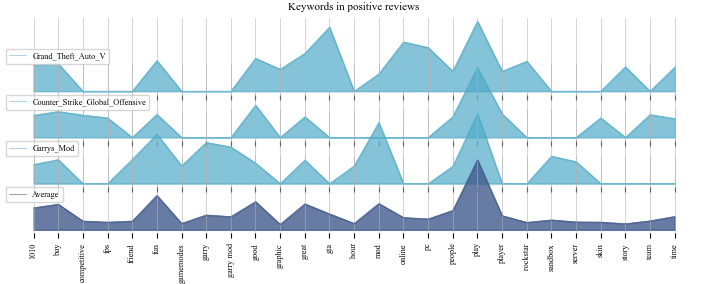

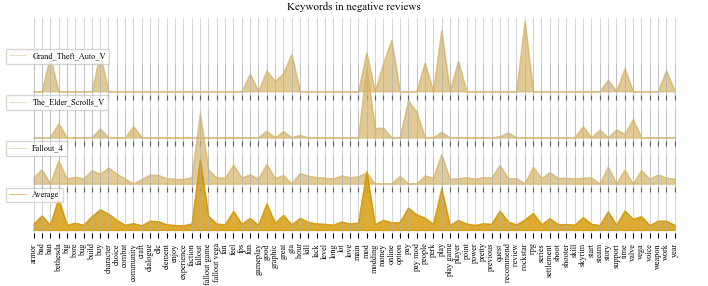

In [6]:
plot_most_interesting(df_dict_pos, df_dict_neg, word_plot_name='wordcount_plot_report', max_df=1.0, min_df=0.08, ngram_range=(1, 2), thresh_rel_diff=0.0, thresh_rel=0.08)